# Compressed sensing project : study of non-negative matrix factorization and online dictionary learning



Students : Hugo Vallet, Guillaume Carbajal

# ---------------------------------------------------------------------------------------------------------------
# Summary :
## I / Introduction
## II / Some definitions
## III / The Jester dataset
## III / Implementation and testing of Seung & Lee paper "Non-negative Matrix Factorization"
#### With the Euclidian distance as metric
#### With the Kullback Leibler divergence as metric
## IV / Study of the theorical bound for NMF proposed by Maurer & Pontil
## V / Going further than NMF : group-structured sparse online matrix factorization

# ---------------------------------------------------------------------------------------------------------------


# I / Introduction

There are 2 types of recommender systems:

### 1. Content-based approach
They make profiles of users by identifying characteristic features about them: city, age, sex, etc. They also make profiles of items: type of product, product description, etc. However, there are 2 main limitations to this approach: on the one hand, it is a laborious task to collect all this information; on the other hand, collecting this information is a privacy-related problem.

### 2. Collaborative filtering
These systems only use features of past activities of the users: transaction history (such as Amazon does), user satisfaction expressed in ratings. Collaborative filtering algorithms lie in the following hypothesis: a group of people who have similar tastes in the past might also agree on their tastes in the future. Therefore,these algorithms seek to identify relationships between items and users.

Since the early 1990s, several collaborative filtering-related papers were published to tackle the problem. The Netflix Prize, held from 2007 to 2009, boosted the interested in these algorithms. 

Nowadays, most of these algorithms rely on 2 mains parts: Matrix Factorization (MF) and Neighbor-based Approaches. Our project is mainly focused on MF.

# II / Some definitions
The problem of Collaborative Filetring can be expressed as follows. We have:
- $U$: set of $N$ users
- $I$: set of $M$ items
- $R$: ratings of items by users
Therefore, $R$ is a matrix in which users are represented as rows and items are represented as columns. The idea of MF is to approximate by the product of 2 matrices $P$ and $Q$:
$$ R \approx P Q $$
with $P$ is of size $N$ x $K$ and $Q$ is of size $K$ x $M$

$P$ represents the features matrix of the users and $Q$ represents the features matrix of the items. Usually $K \ll N,M$ which decreases the number of parameters needed to learn a model from $NM$ to $NK + KM$. The process of prediction comes as follows:
1. We train a matrix factorization to obtain the 2 matrices $P$ and $Q$
2. To predict a rating $ \hat{r_{ui}}$ for a given item $i$ for a user $u$, we just take the $u^{th}$ row of $P$ and apply the dot product with the $i^{th}$ of $Q$:
$$ \hat{r_{ui}} = \sum \limits_{k=1}^{K} p_{uk} q_{ki} = \mathbf{p_{u}} \mathbf{q_{i}} $$

This method mainly applies for batch methods: we assume that we have all the set of users to make our predictions of new $\hat{r_{ui}}$. However, we will see in part IV that we can't apply the same reasoning for online methods.

The intuition behind this statement is related to what is called $\it Dictionary$  $\it Learning$: let us consider a set $X = (x_1, . . . , x_N) ∈ \mathbb{R}^{M×N}$ of $N$ signals of dimension $M$. Dictionary learning is a matrix factorization problem that aims to represent these signals as linear combinations of dictionary elements, denoted here by the columns of a matrix $D = (d_1, . . . , d_K) ∈ \mathbb{R}^{M×K}$. More precisely, the dictionary $D$ is learned along with a matrix of decomposition coefficients $A = (\alpha_1, . . . , \alpha_n) \in
\mathbb{R}^{K×N}$, so that $x_i \approx D \alpha_i $ for every signal $x_i$ and for a given loss metrics. For example, PCA can be seen as a $\it Dictionary$ $\it Learning$ task, in which the components of the dictionary are orthogonal.

In order to measure the performance of our models with a validation set $V$, 2 main metrics are used:
- the Root Mean-Square Error:  $RMSE = \sqrt{\frac{1}{|V|} \sum (\hat{r_{ui}} - r_{ui})^2}$
- the Absolute Mean Error: $AME = \{\frac{1}{|V|} \sum |\hat{r_{ui}} - r_{ui}|$

In this project, we will only focuse on the RMSE, as it is the metric used by Seung&Lee and by Scabo & Lorincz (the 2 main papers we studied).

We define our $\it Dictionary$ $\it Learning$ project in 2 different tasks:
1. Analyzing a batch method for collaborative filtering: Non Negative Matrix Factorization (NMF)
2. Analyzing an online method: Online Structured Sparse Dictionary Learning (OSDL)


In [15]:
import numpy as np
import pandas as pd
import cvxopt

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
from time import time

In [17]:
from sklearn.metrics import mean_squared_error

# III / The Jester dataset

For our 2 task, we will use the Jester dataset, which consists of 100 jokes rated by 24,983 users.

In [18]:
xl = pd.ExcelFile('jester-data-1.xls')
xl.sheet_names
df = xl.parse('jester-data-1-new', header = None)
nb_jokes_user = df[0]
del df[0]
df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [12]:
n_users = df.shape[0]
n_items = df.shape[1]
print str(n_users) + ' users'
print str(n_items) + ' items'

24983 users
100 items


The missing values (non rated elements of the rating matrix) are denoted by the value 99.

In [13]:
ratings = np.array(df)
ratings

array([[ -7.82,   8.79,  -9.66, ...,  99.  ,  99.  ,  99.  ],
       [  4.08,  -0.29,   6.36, ...,   0.34,  -4.32,   1.07],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       ..., 
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [ 99.  ,  99.  ,  99.  , ...,  99.  ,  99.  ,  99.  ],
       [  2.43,   2.67,  -3.98, ...,  99.  ,  99.  ,  99.  ]])

Then we seperated the ratings matrix into 3 matrices: $R_{train}$, $R_{val}$ and $R_{test}$.

In [14]:
## Partition the ratings into train / validation set
R_train = ratings[:10000]
R_val = ratings[10000:20000]
R_test = ratings[20000:]

# ---------------------------------------------------------------------------------------------------------------
## IV / Non-negative Matrix Factorization (NMF)

We wanted here to study Seung & Lee's "Algorithms for Non-negative Matrix Factorization" paper. They propose two types of non-negative factorization (NMF) : one that minimizes a least-squares distance and one that minimizes the Kullback-Leibler divergence (in the case that our initialization matrix is a probability matrix).

## Least square NMF

Here is the problem setting:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }||V-WH||_2^2\text{ under constraints } W,H>0
$$


The algorithm, similarly to a classical gradient descent, will start with random W and H. Then we will apply the following update rules allowing us to converge to a local minima (the problem is non convex w.r.t. W,H).

$$
H \leftarrow H\odot\frac{W^TV}{W^TWH}
$$

$$
W \leftarrow W\odot\frac{VH^T}{WHH^T}
$$

With $\odot$ standing for element-wise product and $-$ standing for element-wise division.

In [4]:
def non_negative_threshold(Z):
    neg_coefs = Z<0
    Z[neg_coefs] = 0
    return Z

In [19]:
def ls_solver(V,W,H,t=100,verbose=False):
    
    def update_h(V,W,H):
        factor1 = np.dot(W.T,V)
        factor2 = np.dot(np.dot(W.T,W),H)
        return H*factor1/factor2

    def update_w(V,W,H):
        factor1 = np.dot(V,H.T)
        factor2 = np.dot(W,np.dot(H,H.T))
        return W*factor1/factor2

    def error(V,W,H):
        return lin.norm(V-np.dot(W,H))
    
    
    
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

The first thing to do is to slightly modify Rtrain so that all elements are non negative, and that missing values are "far" from observed values: add 20 to all elements and put missing values to 0.

In [20]:
R_train
R_train = R_train + 20
R_train[R_train == 119] = 0

In order to measure our predictions on Rtrain, we extract a dense matrix, i.e. a submatrix of Rtrain with no missing values inside.

In [21]:
p = R_train.shape[1]
for i in range(p):
    non_zero_line = R_train[:,i].nonzero()[0]
    R_train = R_train[non_zero_line]
    if i % 10 == 0:
        print(i)
    if len(R_train[:,i].nonzero()[0]) < 4000:
        break

0
10
20
30
40
50
60
70


In [22]:
R_train.shape

(3112L, 100L)

In [23]:
R_train = R_train[:,:70]

Then, we remove 10 item ratings per user, make our predictions on the matrix and compare it to the dense matrix Rtrain

In [24]:
R_test = R_train.copy()
nb_items_to_remove = 10
for j, jtem in enumerate(R_train):
    ## Take 1st row of R_train
    x = jtem.copy()

    #remove nb_items_to_remove values of x_O_test
    index_pred = sorted(np.random.choice(len(x), nb_items_to_remove, replace = False))
    x[index_pred] = 0

    R_test[j] = x

In [25]:
R_test

array([[  0.  ,  19.71,  26.36, ...,  21.12,  20.78,  27.52],
       [ 13.83,  16.46,  20.44, ...,  11.02,  18.06,   0.  ],
       [ 26.84,   0.  ,  29.17, ...,  15.78,  10.19,  17.91],
       ..., 
       [ 27.04,  27.14,  28.69, ...,   0.  ,  27.77,  23.3 ],
       [ 21.8 ,  19.81,  17.33, ...,  23.98,  18.93,   0.  ],
       [ 23.74,  23.93,  23.4 , ...,  24.81,  24.47,   0.  ]])

In [26]:
R_train

array([[ 24.08,  19.71,  26.36, ...,  21.12,  20.78,  27.52],
       [ 13.83,  16.46,  20.44, ...,  11.02,  18.06,  13.01],
       [ 26.84,  23.16,  29.17, ...,  15.78,  10.19,  17.91],
       ..., 
       [ 27.04,  27.14,  28.69, ...,  19.32,  27.77,  23.3 ],
       [ 21.8 ,  19.81,  17.33, ...,  23.98,  18.93,  19.27],
       [ 23.74,  23.93,  23.4 , ...,  24.81,  24.47,  24.85]])

### Test of convergence of the algorithm

The algorithm, according to seung & Lee, is able to converge to a local minima. Here 

In [55]:
V = R_test.copy()
n,m = V.shape
k = 70 #components
iterations = 500
H = non_negative_threshold(15+np.random.randn(k, m)) #Initialize matrices randomly, respecting the non negativity constraints
W = non_negative_threshold(15+np.random.randn(n,k)) #Initialize matrices randomly, respecting the non negativity constraints
start = time()
W,H,err = ls_solver(V,W,H,iterations)
end = time()
print "Total time ellapsed : ", end-start

Total time ellapsed :  5.20599985123


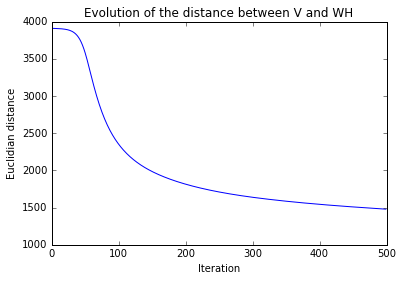

In [56]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("Euclidian distance")
plt.title("Evolution of the distance between V and WH")

In [61]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)
print "RMSE after the training of a Dictionary with euclidian distance : ", RMSE

H2 = non_negative_threshold(np.random.randn(k, m))
W2 = non_negative_threshold(np.random.randn(n,k))
MSE = mean_squared_error(R_train, W2.dot(H2))
RMSE = np.sqrt(MSE)
RMSE
print "RMSE with purely random dictionary : ", RMSE

RMSE after the training of a Dictionary with euclidian distance :  8.74967277281
RMSE with purely random dictionary :  12.0439296406


### Comments:
- Convergence is fast: it converges after 200 iterations.
- The running time is also fast: 5.75 s
- RMSE seems good as random predictions give a worse RMSE.

## Kullback-Leibler NMF

Here the problem setting is similar, the only diference resides in the distance minimized:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }KL(V,WH)\text{ under constraints } W,H>0
$$


Here again, Lee and Seung propose a multiplicative update rule

$$
H \leftarrow H\odot \frac{W^T\frac{V}{WH}}{W^T\mathbb{1}^{n,m}}
$$

$$
W \leftarrow W\odot \frac{\frac{V}{WH}H^T}{\mathbb{1}^{n,m}H^T}
$$

with $\odot$ the element-wise matrix product, $-$ the element-wise division and $\mathbb{1}^{n,m}$ the real-valued matrix of size $(n,m)$ with all its coefficients equal to 1.

_Note for the reader : the updates rules here are not exactly the same form as want we can read in Seung & Lee's paper. In fact, to avoid the for-loops to compute the summing terms in Seung & Lee's updates rules, one can use the following paper_ http://sig.umd.edu/publications/Tjoa_ICASSP2_201003.pdf _, formula (5), for the Kullback divergence based udpdate. In all cases, with the notations we used, it is trivial to see that the two formulations are strictly the same !_

In [58]:
def kl_solver(V,W,H,t=100,verbose=False):
    
    def update_h(V,W,H):
        n,m = V.shape
        unit_vector = np.ones((n,m))
        factor1 = np.dot(W.T,V/np.dot(W,H))
        factor2 = np.dot(W.T,unit_vector)
        return H*factor1/factor2

    def update_w(V,W,H):
        n,m = V.shape
        unit_vector = np.ones((n,m))
        factor1 = np.dot(V/np.dot(W,H),H.T)
        factor2 = np.dot(unit_vector,H.T)
        return W*factor1/factor2
    

    def error(V,W,H):
        return lin.norm(V-np.dot(W,H))
    
    
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

In [59]:
H = non_negative_threshold(15+np.random.randn(k, m)) #Same initialization as before
W = non_negative_threshold(15+np.random.randn(n, k)) #Same initialization as before

start = time()
W,H,err = kl_solver(V,W,H,iterations)
end = time()
print "Total time ellapsed : ", end-start

Total time ellapsed :  9.00300002098


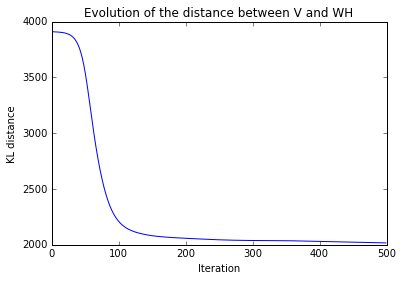

In [60]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("KL distance")
plt.title("Evolution of the distance between V and WH")

In [63]:
MSE = mean_squared_error(R_train, W.dot(H))
RMSE = np.sqrt(MSE)
print "RMSE after the training of a Dictionary with KL distance : ", RMSE

RMSE after the training of a Dictionary with KL distance :  8.74967277281


### Comments:
- Convergence is very fast: it converges after only 100 iterations.
- The running time is slower: 9.3 s
- RMSE is not very good compared to the first solver. The 2nd algorithm seems to overfit.

## Conclusion:
### Advantages
- Convergence for both algorithms is fast, and the Kullback-Leibler Solver is almost twice as fast as the Least-Square Solver.
- The running time for both algorithms is quite fast (ODG: )

### Drawbacks
- Compared to other results with the Jester dataset, we should have obtained a RMSE score ranked between 7 and 4. To prove this assumption, we noticed that, given 2 random matrices $W$ and $H$, the RMSE was lower than for our 2 NMF algorithms.
- This is due to overfitting. The matrix factorization can overfit for users with few (no more than $K$) ratings: assuming that the feature vectors $H$ of the items  rated by the user are linearly independent and $H$ does not change, there exists a user feature vector $W_u$ with zero training error. Thus, there is a potential for overfitting, if $\eta$ and the extent of the change in $H$ are both small.
- A common way to avoid overfitting is to apply regularization by fixing the dictionary $W$ and by penalizing the square of the Euclidean norm of the weights, i.e. the features matrix of items $H$. NMF induces sparsity a but, but it is not enough to avoid overfitting.
- Another drawback is that these 2 algorithms cannot be used for real data, that is to say, they are not scalable. Indeed, the Jester dataset is very small compared to MovieLens for example. In addition, we have only taken a small part of this dataset.
- Finally, the 2 algorithms don't deal with missing values: we can only measure the RMSE if the rating matrix is dense. However, this never appears with real data.

# ---------------------------------------------------------------------------------------------------------------

# IV / Link with the paper K-Dimensional Coding Schemes in Hilbert Spaces

n order to link the NMF to the paper, let's take a look at the reconstruction error defined in the paper:
$$ f_T(x) = \min_{y \in Y}{\| x - T y\|^2} $$
and
$$ \hat{y} = \text{arg } \min_{y \in Y}{\| x - T y\|^2} $$

To approximate $\mathbb{E}_{x \text{ ~ } \mu} f_T(x)$, we use the empirical risk defined as follows: 
$$\frac{1}{m} \sum \limits_{i=1}^m f_T(x_i)$$
which corresponds to the MSE in our case, with $ x_i$ a user i of the rating matrix $R$

The general theorem of the autors give us a bound on the "regret" $ \mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i)$ with at least probability $1 - \delta$ as follows:

$$\mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i) \leq \frac{K}{\sqrt{m}}\left(14 \| \mathcal{T} \|_{Y} + \frac{b}{2} \sqrt{\ln{16 m \| \mathcal{T}}\|_Y^2} \right) + b \sqrt{\frac{\ln{1/\delta}}{2 m}}$$
with the following notations:
$$\mathcal{T} = \{T: T \in \mathcal{L}(\mathbb{R}^K, H)$$

$$ \| \mathcal{T} \|_Y = \sup_{T \in \mathcal{T}}{\| T \|_Y} = \sup_{T \in \mathcal{T}}{\sup_{y \in Y}{\| T y\|}} $$

In the case of NMF, we have the following constraints :
 $$\|T e_k \| = 1, \langle T e_k , T e_l\rangle \geq 0, 1 \leq k,l \leq K$$

Here $T$ refers to the matrix $W$ - i.e. the dictionary $D$ we defined in the introduction.

Let $\{e_1...e_K\}$ be the canonical base of $\mathbb{R}^K$.
To apply this bound to the NMF framework we need to be able to fix $b$ and $||\mathcal{T}||_Y$
In the particular case of NMF, all the columns of T are positive and Y is positive and restricted to the $l_1$-ball of $\mathbb{R}^K$ ie $\forall i$ we have $y_i<1$. Thus we have :

$$
||Ty|| = ||\sum_{k=1}^{K} y_k T e_k ||
$$
$$
\leq \sum_{k=1}^{K} |y_k| ||T e_k|| \text{ with triangle inequality}
$$
$$
= \sum_{k=1}^{K} y_k ||T e_k|| \text{ because y postive}
$$
$$
\leq \sum_{k=1}^{K} ||T e_k|| 
$$
$$
\leq (\sum_{k=1}^{K} ||T e_k||^2)^{1/2}
$$
$$
= K^{1/2} \text{ in the case of NMF, because here $||Te_k|| = 1$ thanks to a re-normalization without loss of generality thanks to Lemma 2 demonstrated by the autors.}
$$

Thus,
$$
||\mathcal{T}||_Y = \sup_{T \in \mathcal{T}} \sup_y ||Ty|| \leq K^{1/2}
$$

So, for NMF, we can use the bound of theorem 2 with $||\mathcal{T}||_Y = K^{1/2}$ and $b=0$ which give the form of the NMF bound proposed by the autors :

 $$\mathbb{E}_{x \text{ ~ } \mu} f_T(x) - \frac{1}{m} \sum \limits_{i=1}^m f_T(x_i) \leq \frac{K}{\sqrt{m}}\left(14 \sqrt{K} + \sqrt{\ln{16 m K}} \right) + \sqrt{\frac{\ln{1/\delta}}{2 m}}$$

# ---------------------------------------------------------------------------------------------------------------

# V / Going further than NMF : Online Structured Dictionary Learning (OSDL)

Here, the paper we studied is the following : https://www.cs.cmu.edu/~bapoczos/articles/szabo12collaborative.pdf. However, this paper doesn't provide updates rules and practical details about the algorithm used. We studied, then, their other paper : http://www.gatsby.ucl.ac.uk/~szabo/publications/szabo11online_with_supplementary_material.pdf which provides the pseudo-code (see supplementary part) of the algorithm they proposed.

## Main differences with Seung & Lee algorithm

1. This is an online algorithm (to be more precise, this algorithm is presented as a generalization of Mairal, Bach, Ponce & Sapiro's Online Dictionary Learning : http://www.di.ens.fr/willow/pdfs/icml09.pdf).
2. It takes into account overlapping group structures which could be present in the observed data, thanks to a special penalty term.
3. Applies non-convex sparsity inducing regularization.
4. Can deal with missing information.


## Overwiew of the problem

The algorithm is based, like the NMF, on a alternated minimization scheme.

### Minimization on alpha

Here, because we are solving an online matrix factorization problem, we don't see the whole dataset $X$. That's why, for a fixed D we have the following problem to solve :

$$
\min_{\alpha} \frac{1}{2} ||x - D\alpha||^2_2 + \kappa\Omega(\alpha)
$$
$$
x \in \mathbb{R}^{d_x}
$$
$$
\alpha \in \mathbb{R}^{d_\alpha}
$$
$$
D \in \mathbb{R}^{d_x,d_\alpha}
$$
$$
\kappa > 0
$$

Here the penalty is more complex than just a classical $l_1$ penalty : 

$$
\Omega(\alpha) = ||(||d^g \odot \alpha||_2)_{g \in G}||_\eta
$$

- $d^g$ is a vector containing 1 on indices contained in group $g$ and 0 otherwise.
- $g$ is the index of a group of indices belonging to $G$, a set of groups (called structure). If $G$ is a partition of $\{1...p\}$ and $\eta$ is fixed to 1 then it is very easy to see that this penalty is simply the group Lasso. If $G$ is just the singletons $\{i\}$ with $i \in \{1..p\}$ and $\eta$ fixed to 1, the penalty is just the classical Lasso penalty.

### Minimization on D
#### Basic case
Notation :
$$
l(x_i,D) = \min_{\alpha}[ \frac{1}{2} ||x_i - D\alpha||^2_2 + \kappa\Omega(\alpha)]
$$
Here, when the $\alpha$ minimizing the quantity above is known, we want to minimize the following problem :
$$
\min_{D} \frac{1}{K} \sum_{i=1}^{T} w_i l(x_i,D)
$$
$$
w_i = (\frac{i}{T})^\rho
$$
- Here it is important to notice that they introduce a weighting term $w_i$ which is decreasing when T increases. That is to say, an old example will have a lot less weight in the quantity to minimize than a recently seen example. Thus, the algorithm is fully online : if we keep it running provinding it an endless flow of data, it will continuously adapt itself to the new data points observed.
- K is just a normalization factor to make the sum of the weights equal to one.
- $\rho$ is a "forgetting factor", quantifying how fast the algorithm will forget the past examples when fitting D. The fact is that when you put $\rho$ equal to 0 you get the minimization problem already covered in Mairal's paper : the function is then, just an average of the individual losses of the examples seen.

#### Dealing with missing data points
When there are missing data points in the training set (for example, in the Jester, missing jokes ratings), the autor proposed a more general reformulation of the problem :

$$
l(x_i,D) = \min_{\alpha}[ \frac{1}{2} ||\Delta_i(x_i - D\alpha)||^2_2 + \kappa\Omega(\alpha)]
$$
With $\Delta_i$ a diagonal matrix of the following form :


$$
\begin{equation}
(\Delta_i)_{q,q} =
  \left\{
    \begin{split}
     1 \text{ if   the qth item for the user i is observable}\\ 
     0 \text{ otherwise} \\
    \end{split}
  \right.
\end{equation}
$$

Then he can computes the form of the updates rules just taking a gradient and solving the linear system :
$$
D^* = argmin
<=>
\nabla_D[ \frac{1}{K} \sum_{i=1}^{T}\frac{w_i}{2} ||\Delta_i(x_i - D\alpha)||^2_2 + \kappa\Omega(\alpha) ] = 0
<=>
\nabla_D[ \sum_{i=1}^{T}w_i ||\Delta_i(x_i - D\alpha)||^2_2 ] = 0 \text{ because here $\alpha$ is fixed}
$$

The resolution of this equation and some tricks fully described in the paper allow the autors to get the update rule for D.
In particular, to do so, they are obliged (as Mairal in his own online learning algo) to introduce some intermediary matrices B,C, and E to compute the update of D (see the pseudo-code in next section).



## Coding the OSDL algorithm
Before starting to code the OSDL algorithm we need 2 functions :
- a function to generate the structure used as an input argument for the OSDL algorithm
- a function to compute the $\Delta_i$ matrices for each new line of data we see
Here are the implementations of these two functions :


In [36]:
def group_structure(d_alpha, struct, nb_group=3):
    if struct == 'lasso':
        d_G = []
        for i in range(d_alpha):
            G = np.zeros(d_alpha)
            G[i] = 1
            d_G.append(G)
            
    if struct == 'group_lasso':
        # fonction rand pour donner le nombre d'indices dans chaque partition de {1...d_alpha}
        # Exemple: n paritions
        partition = sorted(np.random.choice(d_alpha, nb_group-1, replace = False))

        ## shuffle les indices
        shuffled_indices = np.random.choice(d_alpha, d_alpha, replace = False)
        
        ## Création des groupes
        x = []
        for i, item in enumerate(partition):
            if i == 0:
                x.append(shuffled_indices[:item])
            elif i == len(partition) - 1:
                x.append(shuffled_indices[partition[i-1]:item])
                x.append(shuffled_indices[item:])
            else:
                x.append(shuffled_indices[partition[i-1]: item])
        d_G = []
        for i, item in enumerate(x):
            G = np.zeros(d_alpha)
            G[item] = 1
            d_G.append(G)
            
    return d_G

def delta(r,X_batch):
    X_r = X_batch[:,r]
    delta = np.eye((d_x))
    non_observable = X_r==99
    delta[non_observable,non_observable]=0
    return np.array(delta)

In the paper, the pseudo-code for the OSDL is the following.
<img src='Pseudo-code-main.png'>

Our implementation is the following :

In [44]:
def OSDL(X,D0,T,R,Group_struct,rho,kapa,eta,epsilon = 0.00001,T_alpha = 5,T_D = 5):
    d_x, N = X.shape
    C = np.zeros((d_x,d_x,d_alpha))
    B = np.zeros((d_x,d_alpha))
    E = np.zeros((d_x,d_alpha))
    alpha = np.random.rand(d_alpha,R)
    D = np.random.rand(d_x,d_alpha)
    
    for t in range(T):
        print "iteration N° : ",t
        #Draw samples for mini-batches
        X_batch = X[:,t*R:(t+1)*R] #Dans notre cas on coupe artificiellement le dataset en batchs
        
        #----------------------------------------------------------------------------------------        
        #Compute alphas_r representations
        for r in range(R):
            x_temp = list(X_batch[:,r])
            ## Save indexes of observed values
            indices = [i for i, item in enumerate(x_temp) if item != 99]
            #remove missing values of first row of R_train
            x_O = [a for a in x_temp if a != 99]
            # save the observed rows of D
            D_O = D[np.array(indices),:].copy() 
            #Compute the r column of alpha
            alpha[:,r] = min_alpha(x_O, D_O, alpha[:,r], eta, d_alpha, T_alpha, epsilon, d_G)
        
        
        #----------------------------------------------------------------------------------------    
        #Update the statistics
        gamma=(1-1/float(t+1))**rho
        
        #Update B
        sum_b = np.zeros((d_x,d_alpha))
       
        for r in range(R):
            sum_b += np.dot(np.expand_dims(np.dot(delta(r,X_batch),X_batch[:,r]),axis=1),np.expand_dims(alpha[:,r],axis=1).T)
        B = gamma*B + 1/float(R)*sum_b
        
        #Update all the C_j matrices and e_j vectors
        sum_c = np.zeros((d_x,d_x))
        
        for j in range(d_alpha):
            C_j = C[:,:,j]
            E[:,j] = gamma*-E[:,j] #partial update on e_j
            
            for r in range(R):
                sum_c += delta(r,X_batch)*alpha[j,r]**2
            
            C_j = gamma*C_j + 1/float(R)*sum_c
            C[:,:,j] = C_j
        #----------------------------------------------------------------------------------------
        #Update dictionnary 
        D = dictionary(C,B,E,X_batch,T_D, alpha,D,d_x,d_alpha,R)
        #----------------------------------------------------------------------------------------
        #Finish update on E
        sum_e = np.zeros(d_x)
        for j in range(d_alpha):
            e_j = E[:,j]
            for r in range(R):
                sum_e += np.dot(np.dot(delta(r,X_batch),D),alpha[:,r])*alpha[j,r]
                
            e_j = e_j + 1/R*sum_e
            E[:,j] = e_j #final update
        
    
    return D    
    


The pseudo-code for the update of the alphas is given here :
<img src='Pseudo-code-representation.png'>

Our implementation is the following :

In [45]:
def min_alpha(x_O, D_O, alpha, eta, d_alpha, T_alpha, epsilon, d_G):
    ## Minimisation on alpha
    for t in range(T_alpha):

        ## Compute z
        norm_G_alpha = []

        for j in d_G:
            norm_G_alpha.append(np.linalg.norm(j * alpha, ord =2))
        coef = (np.linalg.norm(norm_G_alpha, ord = eta) ** (eta - 1))

        norm_G_alpha = np.array(norm_G_alpha)
        norm_G_alpha = np.power(norm_G_alpha, 2 - eta)
        z = norm_G_alpha * coef
        for i, item in enumerate(z):
            z[i] = max(item, epsilon)

        
        ## Compute alpha
        ksi = []
        for j in range(d_alpha):
            coef_ksi = 0.0
            for i, item in enumerate(z):
                coef_ksi += (d_G[i][j])**2 / item 
            ksi.append(coef_ksi)
        
        ### Pour résoudre le pb de progammation quadratique, on utilise cvxopt
        # P = kappa * diag(ksi) + D_O.T.dot(D_O)
        # Q = - D_O.T.dot(x_O)
        P = kappa * np.diag(ksi) + D_O.T.dot(D_O)
        P = cvxopt.matrix(P)

        q = - D_O.T.dot(x_O)
        q = cvxopt.matrix(q)

        sol = cvxopt.solvers.qp(P,q)
        alpha = np.ravel(sol['x'])
    return alpha

The pseudo-code proposed for the update of the dictionary is the following :
<img src='Pseudo-code-dictionary.png'>

We propose here the following implementation :

In [46]:
def dictionary(C,B,E,X_batch,T_D, alpha,D,d_x,d_alpha,R):
       
    #NOTE ici alpha est la concatenation des vecteurs alphas updatés précédement, pour chaque ligne du batch (R lignes). 
    #C'est une matric de taille (d_alpha,R)
    
    for t in range(T_D):
        for j in range(d_alpha):
            #compute e_j
            sum_r=0
            for r in range(int(R)) :  
                sum_r += np.dot(np.dot(delta(r,X_batch),D),alpha[:,r])*alpha[j,r]
            e_j_temp = E[:,j] + 1/R * sum_r
            #compute u_j by solving linear system
            C_j = C[:,:,j]
            u = np.linalg.solve(C_j, B[:,j]-e_j_temp+np.dot(C_j,D[:,j]))
            #u = np.linalg.lstsq(C_j, B[:,j]-e_j_temp+np.dot(C_j,D[:,j]))[0]
            #contraints u_j to keep only positive coefficients
            u[u<0]=0
            #compute d_j by projection of u on the good space
            D[:,j] = u / max(np.linalg.norm(u),1)
            
    return D 

## Remarks

### Similarities with Mairal's paper
First, as far as the algorithm is online, we can notice some __similarities__ with Mairal's algorithm : 
- This is a alternated minimization scheme, on alpha and on D.
- Alpha is updated with a fixed D using a quadratic programing solver (for ex the one implemented in cvxopt). Mairal proposed, on the other hand, a LARS solver (for ex the one implemented in sklearn)
- The dictionary is updated using intermediary matrices : A,B in Mairal, E,B,C,delta in this paper.

### Differences with Mairal's paper
- We use batches of data. That is to say, instead of doing the online procedure line of observation by line of observation, we take multiple lines in the same time, we concantenate them and, then, start updating alpha and D.
- Because the penalty is a lot more complex than Mairal's one, the update of alpha is different and needs extra-steps before calling the solver (i.e computing the "argmin step"). 
- Mairal paper doesn't talk about incomplete data. In fact, here, most of our entries are incomplete. That's why, in the updates formulas, there is a $\Delta_i$ matrix ivolved while this factor is absent of Mairal work. 
- Finally, because the function to optimize in D with a regret factor (not implemented in Mairal's) and because of the previous point, the updates rules are more complex. 



# Learning D and predicting ratings

Here, because the algorithm is online we cannot use a prediction of the form :
$$
\hat{X} = DA
$$
because the learning algorithm is only able to return a learnt dictionary $D$. The $\alpha$s are scratched at each iteration. Thus, we used the following technique :
- Learn D on a train dataset with the OSDL algorithm
- Then, iteratively, make a prediction for a new data point belonging to the test data set letting D unmodified and modifying the $\alpha$ at each step, like in the training phase. At each step the prediction is then :
$$
\hat{x} = D\alpha
$$

### Split the dataset

In [47]:
R_train = ratings[:10000]
R_val = ratings[10000:20000]
R_test = ratings[20000:]

### Initialize parameters

In [48]:
d_alpha = 100
d_x = 100
alpha = np.random.randn(d_alpha)
#Number of iterations in the alpha update
T_alpha = 5
#Number of iterations in the D update
T_D = 5
#Number of iterations in the OSDL learning (corresponding to the number of batches)
T = 150
#Size of batches
R = 8
#Regularization parameters
epsilon = 10**(-5)
rho = 32
eta = 0.5
kappa = 1. / (2**10)
#Structure
d_G = group_structure(d_alpha, struct='lasso', nb_group=10)
#Initialization dictionary
D0 = np.random.rand(d_x,d_alpha)

### Train D

In [49]:
X = R_train.T
D = OSDL(X,D0,T,R,d_G,rho,kappa,eta,epsilon,T_alpha,T_D)

iteration N° :  0
iteration N° :  1
iteration N° :  2
iteration N° :  3
iteration N° :  4
iteration N° :  5
iteration N° :  6
iteration N° :  7
iteration N° :  8
iteration N° :  9
iteration N° :  10
iteration N° :  11
iteration N° :  12
iteration N° :  13
iteration N° :  14
iteration N° :  15
iteration N° :  16
iteration N° :  17
iteration N° :  18
iteration N° :  19
iteration N° :  20
iteration N° :  21
iteration N° :  22
iteration N° :  23
iteration N° :  24
iteration N° :  25
iteration N° :  26
iteration N° :  27
iteration N° :  28
iteration N° :  29
iteration N° :  30
iteration N° :  31
iteration N° :  32
iteration N° :  33
iteration N° :  34
iteration N° :  35
iteration N° :  36
iteration N° :  37
iteration N° :  38
iteration N° :  39
iteration N° :  40
iteration N° :  41
iteration N° :  42
iteration N° :  43
iteration N° :  44
iteration N° :  45
iteration N° :  46
iteration N° :  47
iteration N° :  48
iteration N° :  49
iteration N° :  50
iteration N° :  51
iteration N° :  52
ite

## Testing phase

In [50]:
## Take 1st row of R_train
x = list(R_train[0].copy())

## Save indexes of observed values
indices = [i for i, item in enumerate(x) if item != 99]

#remove missing values of first row of R_train
x_O = [a for a in x if a != 99]

# save the observed rows of D
D_O = D[np.array(indices),:].copy() 

In [54]:
def testing_model(D, alpha, nb_items_to_remove, R_test, model = 'NMF', missing_value = 99):
    from sklearn.metrics import mean_squared_error
    ## Define testing set
    # On définit le testing set, on fait la prédiction et on calcule l'erreur dans 1 même boucle
    
    N = R_test.shape[0]
    MSE = 0.0
    #if model == 'NMF':
     #   XXXXXXXX
    if model == 'OSDL':
        for j, jtem in enumerate(R_test):
            ## Take 1st row of R_train
            x = jtem.copy()

            ## Save indexes of observed values
            indices = [i for i, item in enumerate(x) if item != missing_value]
            indices = np.array(indices)

            # save the observed rows of D
            # we will use for prediction of x_O_pred and compare it to x_O
            D_O_test = D[np.array(indices),:].copy() 

            #remove missing values of first row of R_train
            x_O_test = x[indices]

            #remove nb_items_to_remove values of x_O_test
            index_pred = sorted(np.random.choice(len(x_O_test), len(x_O_test) - nb_items_to_remove, replace = False))
            x_O_pred = x_O_test[index_pred].copy()
            D_O_pred = D[index_pred,:].copy()

            #prediction
            alpha_test = min_alpha(x_O_pred, D_O_pred, alpha, eta, d_alpha, T_alpha, epsilon, d_G)

            MSE += mean_squared_error(x_O_test, D_O_test.dot(alpha_test))

        MSE = MSE / N
        RMSE = np.sqrt(MSE)
    return 'MSE: ',MSE, ' RMSE: ', RMSE
        
    

In [55]:
testing_model(D, alpha, 10, R_test, model = 'OSDL', missing_value = 99)

('MSE: ', 23.990990881590296, ' RMSE: ', 4.8980599099633615)

We find a RMSE which is in the order of what is exepected on this dataset (<5) : see Kaggle competition on this particular dataset for instance (https://inclass.kaggle.com/c/uci77B/leaderboard). However, we are still far from the results achieved by the autors of the paper. Multiple reasons could explain that :
- They use a better tuned group-structure whereas our dictionnary is based on a simple Lasso
- They tuned the set of hyperparameters better (with cross-validation)
- Something is going wrong in our implementation of the OSDL learning process (but because of the complexity of the code, this is really hard to check). However, because the testing phase seems to work pretty well, the problem may come from the dictionary update phase...


In [ ]:
## Define similarities

# Normalized scalar product based similarity
def item_similarity_1(q_i, q_j, alpha):
    a = (q_i ).T.dot(q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (max(0, a) / np.sqrt(b * c))** alpha
    
    return s_ij

# Normalized Euclidian distance based similarity
def item_similarity_2(q_i, q_j, alpha):
    a = (q_i - q_j).T.dot(q_i - q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (a / np.sqrt(b * c))**(- alpha)
    
    return s_ij

## Conclusion on OSDL
This algorithm has multiple advantages and drawbacks, here are the main :

### Advantages
- The OSDL algorithm is able to penalize group structures, a lot more complex than simple lasso. This is particularly interesting in image processing where the images could have group-of-pixels structures. Moreover, the wavelet transform has a tree structure which could also be used using OSDL.
- The OSDL algorithm is batch (increase of speed) and online. Thus it can deals with continuous incoming flows of data.
- It is flexible in time thanks to the regret term. The paper proposed by Mairal didn't have this particularity, resulting, after too much iterations, in an avareging of the dictionary (this is bad beacuse if the atoms of the dictionary are too similar, its expressivity is low)
- It is able to treat incomplete data, but, then, the reconstruction error could be really bad.

### Drawbacks
- The pseudo-code proposed by the autors is excessively complex, especially if you compare it to Seug & Lee or to Mairal papers.
- This method is not scalable ! It requires, for the update of D, to store in memory $d_\alpha$ matrices $C_j$ of size $(d_x,d_x)$. This method is particularly not implementable if $d_x$ is high, that is to say if we have a lot of ratings per user. Maybe it explains why the autors chose the Jester dataset ! (which is of size $d_x$ particularly small !)
- Of course, if the dataset was larger, we would also face a slow down when computing the alpha and D updates with quadratic solvers...
- The pseudo-code proposed is not optimized. If you look carefully, we compute some updates in the main loop which are then recomputed in the dictionary update loop. This could have been treated simply, to make things more understandable, we wanted to stick to the paper formulations.
- We don't see how, on the specific problem of collaborative filtering on the Jester dataset, a group structure can be exhibited. We have no information about similarities between items. Thus, it seems strange to prior iteractions/structure between items... Maybe a "bruteforce" approach could have improve the results : simulate randomly a structure, train D, assess the performances, restart a high number of time and keep the best performing random structure.
- This algorithm introduce a lot of hyperparameters ! This could make it more flexible to different datasets, but in the mean time it increases a lot the complexity of the training phase : the only way to fix the hyperparameters is to do extensive grid searching. This operation, of course, is computationally heavy.

